# Experiment Configuration and Execution

In this tutorial we show how to configure and execute an experiment in OpenSBT to test an agent. We show the configuration of the experiment for testing a simplistic agent in a simplified simulator (no GPU required).

_Note: This example is meant for introducing OpenSBT. An application with a high fidelity simulation and a *real-world* SUT is provided [here](https://git.fortiss.org/opensbt/opensbt-core/-/blob/main/doc/jupyter/06_Example_CARLA.ipynb)._

## Toy Example

We refer to this example as Toy Example. The example contains an AEB agent and a pedestrian. Both actors move linear, while the pedestrian has a fixed trajectory and fixed velocity, the ego agent has a predefined path but can modify his velocity. That means, ego brakes when he detects other actors within a predefined distance. We want to test the AEB agent in violating the safety distance of 1m. For this we want to vary the initial velocities of both actors as well the orientation of the pedestrian crossing egos' lane.

In particlar, the pedestrian has a speed in the range of [0.2, 3] m/s, the ego [1, 10] m/s, while the orientation range is [0,180] degrees.

## Defining An Experiment

To define an experiment we need to instantiate [`ADASProblem`](https://git.fortiss.org/opensbt/opensbt-core/-/blob/main/problem/adas_problem.py). `ADASProblem` holds:

- the **scenario**, which can be e.g., an OpenSCENARIO file, or file of another format supported by simulator,
- the **search variables**, whose values are altered to produce (different) scenarios througout the search,
- the **search space**, represented by the lower and upper bounds as arrays,
- the **fitness function**, 
- the **criticality function**, which represents the safety requirements/testing oracle,
- the **simulate function** to trigger the simulator via this function,
- the **simulator-related variables**, i.e., simulation time, sampling time, toggle for visualization.

_Note, that for now the SUT is triggered via the Simulater Interface, as we assume that the SUT is embedded into the simulator. We are working on an update where the SUT can be defined uncoupled from the simulator._

In [1]:
cd opensbt-core

C:\Users\Lev\Documents\fortiss\projects\testing\open-sbt\opensbt-core\docs\jupyter\opensbt-core


In [10]:
import pymoo

from opensbt.model_ga.individual import IndividualSimulated
pymoo.core.individual.Individual = IndividualSimulated

from opensbt.model_ga.population import PopulationExtended
pymoo.core.population.Population = PopulationExtended

from opensbt.model_ga.result  import SimulationResult
pymoo.core.result.Result = SimulationResult

from opensbt.model_ga.problem import SimulationProblem
pymoo.core.problem.Problem = SimulationProblem

from opensbt.algorithm.nsga2_optimizer import NsgaIIOptimizer
from opensbt.experiment.search_configuration import DefaultSearchConfiguration

import os
from opensbt.evaluation.fitness import *
from opensbt.problem.adas_problem import ADASProblem
from opensbt.problem.pymoo_test_problem import PymooTestProblem
from opensbt.experiment.experiment_store import *
from opensbt.algorithm.algorithm import *
from opensbt.evaluation.critical import *
from opensbt.simulation.dummy_simulation import DummySimulator


problem = ADASProblem(
                      problem_name="DummySimulatorProblem",
                      scenario_path="scenarios/dummy_scenario.xosc",
                      xl=[0, 1, 0, 0.2],
                      xu=[180, 10,180, 3],
                      simulation_variables=[
                          "orientation_ego",
                          "velocity_ego",
                          "orientation_ped",
                          "velocity_ped"],
                      fitness_function=FitnessMinDistanceVelocity(),
                      critical_function=CriticalAdasDistanceVelocity(),
                      simulate_function=DummySimulator.simulate,
                      simulation_time=10,
                      sampling_time=0.25
                      )

We have two options to execute the testing experiment: using the console or using the code directly. 

## Experiment Execution (Code)

To start search without console, we instantiate the search algorithms `Optimizer` and call its `run` method to start the search. When the search has finished, we write the results by calling an output method (line 9). The results will be written in the default folder name `results`, if no folder name is passed.

In [5]:
import pymoo

from opensbt.model_ga.individual import IndividualSimulated
pymoo.core.individual.Individual = IndividualSimulated

from opensbt.model_ga.population import PopulationExtended
pymoo.core.population.Population = PopulationExtended

from opensbt.model_ga.result  import SimulationResult
pymoo.core.result.Result = SimulationResult

from opensbt.model_ga.problem import SimulationProblem
pymoo.core.problem.Problem = SimulationProblem

from opensbt.algorithm.nsga2_optimizer import NsgaIIOptimizer

from opensbt.utils import log_utils

log_utils.setup_logging("./log.txt")

# Set search configuration
config = DefaultSearchConfiguration()
config.n_generations = 50
config.population_size = 20

# Instantiate search algorithm
optimizer = NsgaIIOptimizer(
                            problem=problem,
                            config= config)

# Run search
res = optimizer.run()

# Write results
res.write_results(params = optimizer.parameters)

2024-01-26 16:37:58,858 INFO     Logging setup. Writing to file:  ./log.txt
2024-01-26 16:37:58,876 INFO     Running evaluation number 1
2024-01-26 16:37:58,995 INFO     Running evaluation number 2


n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      2 |             - |             -
     2 |       40 |      2 |  0.8062057690 |         nadir


2024-01-26 16:37:59,233 INFO     Running evaluation number 3
2024-01-26 16:37:59,364 INFO     Running evaluation number 4


     3 |       60 |      4 |  0.1239335346 |         ideal
     4 |       80 |      5 |  0.0109796494 |         ideal


2024-01-26 16:37:59,615 INFO     Running evaluation number 5
2024-01-26 16:37:59,738 INFO     Running evaluation number 6
2024-01-26 16:37:59,847 INFO     Running evaluation number 7


     5 |      100 |      2 |  0.0177239531 |         ideal
     6 |      120 |      7 |  0.0285462801 |         ideal


2024-01-26 16:37:59,984 INFO     Running evaluation number 8
2024-01-26 16:38:00,092 INFO     Running evaluation number 9


     7 |      140 |      8 |  0.0066209626 |         ideal
     8 |      160 |     10 |  0.0675421854 |         nadir


2024-01-26 16:38:00,205 INFO     Running evaluation number 10
2024-01-26 16:38:00,319 INFO     Running evaluation number 11


     9 |      180 |     12 |  0.0559461576 |         nadir
    10 |      200 |      7 |  0.0493727870 |         ideal


2024-01-26 16:38:00,447 INFO     Running evaluation number 12
2024-01-26 16:38:00,548 INFO     Running evaluation number 13


    11 |      220 |      6 |  0.0155030235 |         ideal
    12 |      240 |      7 |  0.0042854751 |         ideal


2024-01-26 16:38:00,672 INFO     Running evaluation number 14
2024-01-26 16:38:00,765 INFO     Running evaluation number 15


    13 |      260 |      8 |  0.0210063247 |         ideal
    14 |      280 |      9 |  0.0160264743 |         nadir


2024-01-26 16:38:00,894 INFO     Running evaluation number 16
2024-01-26 16:38:00,998 INFO     Running evaluation number 17


    15 |      300 |     10 |  0.0304703024 |             f
    16 |      320 |      8 |  0.0145401899 |         nadir


2024-01-26 16:38:01,113 INFO     Running evaluation number 18
2024-01-26 16:38:01,212 INFO     Running evaluation number 19


    17 |      340 |      8 |  0.0007595589 |             f
    18 |      360 |     10 |  0.0221143085 |         nadir


2024-01-26 16:38:01,333 INFO     Running evaluation number 20


    19 |      380 |     11 |  0.0009147460 |             f
    20 |      400 |     10 |  0.0129484083 |             f


2024-01-26 16:38:01,602 INFO     Running evaluation number 21
2024-01-26 16:38:01,744 INFO     Running evaluation number 22
2024-01-26 16:38:01,854 INFO     Running evaluation number 23


    21 |      420 |      9 |  0.2264455939 |         nadir
    22 |      440 |      9 |  0.6715220536 |         nadir


2024-01-26 16:38:01,981 INFO     Running evaluation number 24
2024-01-26 16:38:02,091 INFO     Running evaluation number 25


    23 |      460 |     10 |  0.0045010342 |         ideal
    24 |      480 |      9 |  0.1777826824 |         nadir


2024-01-26 16:38:02,215 INFO     Running evaluation number 26
2024-01-26 16:38:02,314 INFO     Running evaluation number 27


    25 |      500 |     10 |  0.0068017084 |         nadir
    26 |      520 |     11 |  0.0057461940 |         ideal


2024-01-26 16:38:02,437 INFO     Running evaluation number 28
2024-01-26 16:38:02,530 INFO     Running evaluation number 29


    27 |      540 |     11 |  0.000000E+00 |             f
    28 |      560 |     11 |  0.0039929965 |             f


2024-01-26 16:38:02,678 INFO     Running evaluation number 30


    29 |      580 |     10 |  0.0563899929 |         nadir
    30 |      600 |     10 |  0.7902145235 |         nadir


2024-01-26 16:38:02,829 INFO     Running evaluation number 31
2024-01-26 16:38:02,965 INFO     Running evaluation number 32


    31 |      620 |     11 |  0.4324865398 |         nadir
    32 |      640 |     11 |  0.0019524028 |             f


2024-01-26 16:38:03,103 INFO     Running evaluation number 33
2024-01-26 16:38:03,337 INFO     Running evaluation number 34


    33 |      660 |     13 |  0.9089546273 |         nadir
    34 |      680 |     14 |  0.0257340822 |         nadir


2024-01-26 16:38:03,502 INFO     Running evaluation number 35


    35 |      700 |     15 |  0.0035235775 |             f


2024-01-26 16:38:03,883 INFO     Running evaluation number 36
2024-01-26 16:38:04,022 INFO     Running evaluation number 37


    36 |      720 |      4 |  0.0515180314 |         nadir


2024-01-26 16:38:04,294 INFO     Running evaluation number 38


    37 |      740 |      4 |  0.0012378756 |             f
    38 |      760 |      6 |  0.1148001842 |         nadir


2024-01-26 16:38:04,445 INFO     Running evaluation number 39
2024-01-26 16:38:04,673 INFO     Running evaluation number 40


    39 |      780 |      6 |  0.000000E+00 |             f
    40 |      800 |      7 |  0.4166724083 |         nadir


2024-01-26 16:38:04,798 INFO     Running evaluation number 41
2024-01-26 16:38:04,909 INFO     Running evaluation number 42
2024-01-26 16:38:05,027 INFO     Running evaluation number 43


    41 |      820 |      6 |  0.0030147064 |             f
    42 |      840 |      6 |  0.000000E+00 |             f


2024-01-26 16:38:05,187 INFO     Running evaluation number 44


    43 |      860 |      7 |  0.0002184429 |             f
    44 |      880 |      8 |  0.0843638108 |         nadir


2024-01-26 16:38:05,307 INFO     Running evaluation number 45
2024-01-26 16:38:05,496 INFO     Running evaluation number 46


    45 |      900 |      8 |  0.000000E+00 |             f
    46 |      920 |      8 |  0.0217744935 |         nadir


2024-01-26 16:38:05,611 INFO     Running evaluation number 47
2024-01-26 16:38:05,730 INFO     Running evaluation number 48


    47 |      940 |      9 |  0.7066901459 |         nadir
    48 |      960 |      6 |  0.1789871237 |         nadir


2024-01-26 16:38:05,864 INFO     Running evaluation number 49
2024-01-26 16:38:06,017 INFO     Running evaluation number 50
2024-01-26 16:38:06,131 INFO     =====[NSGA2] Writing results to: 


    49 |      980 |      6 |  0.0249423389 |             f
    50 |     1000 |      6 |  0.000000E+00 |             f


2024-01-26 16:38:06,137 INFO     C:\Users\Lev\Documents\fortiss\projects\testing\open-sbt\opensbt-core\docs\jupyter\opensbt-core\results\DummySimulatorProblem\NSGA2\26-01-2024_16-38-06\


We can then for instance inspect the visualization of test cases that has been found during search. Note, that visualizations of the "fitness"-optimal scenarios are stored in the "gif" folder.

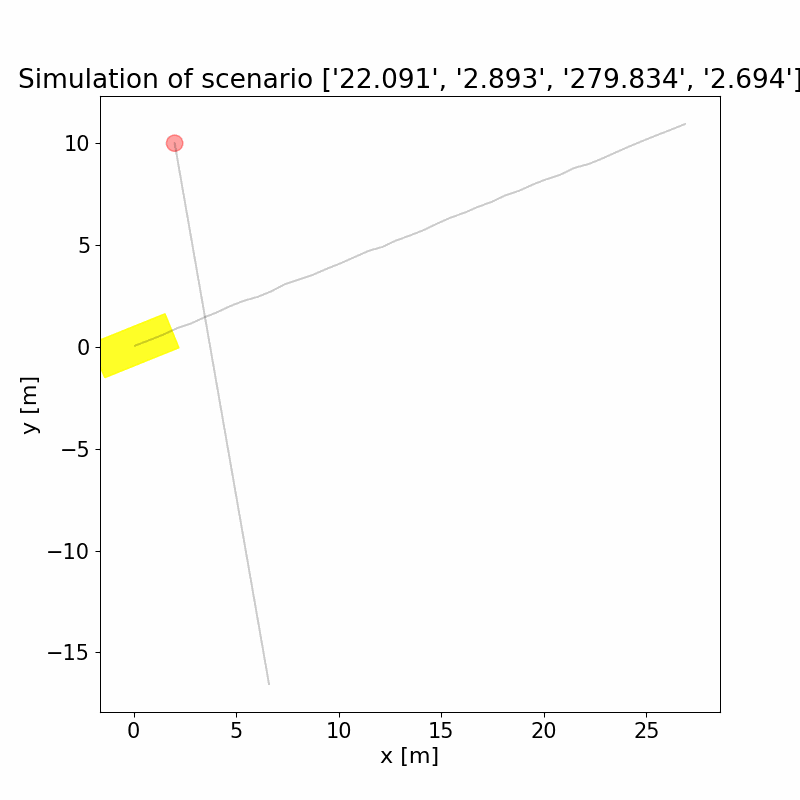

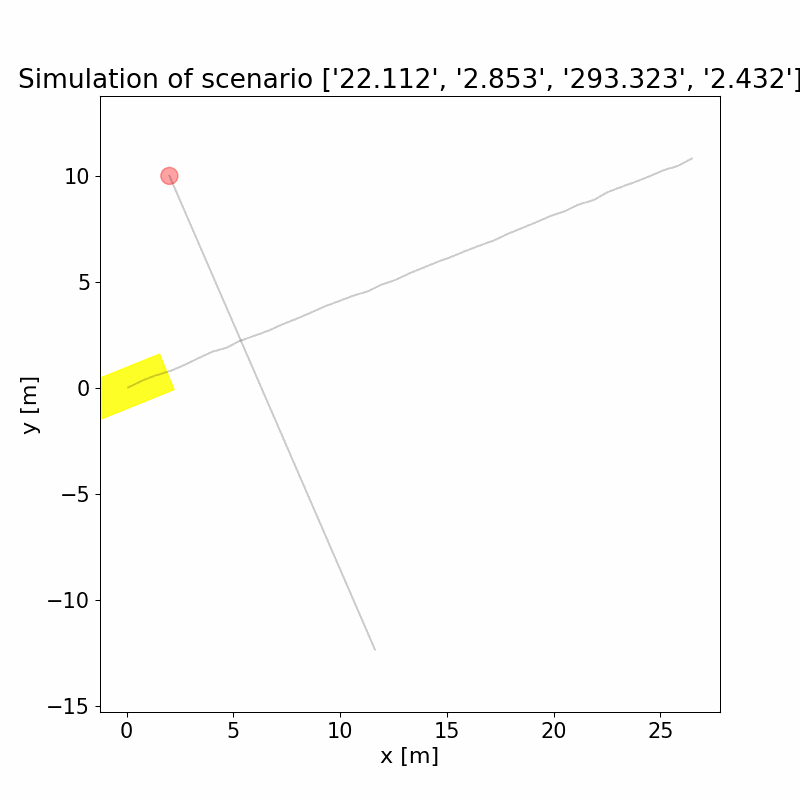

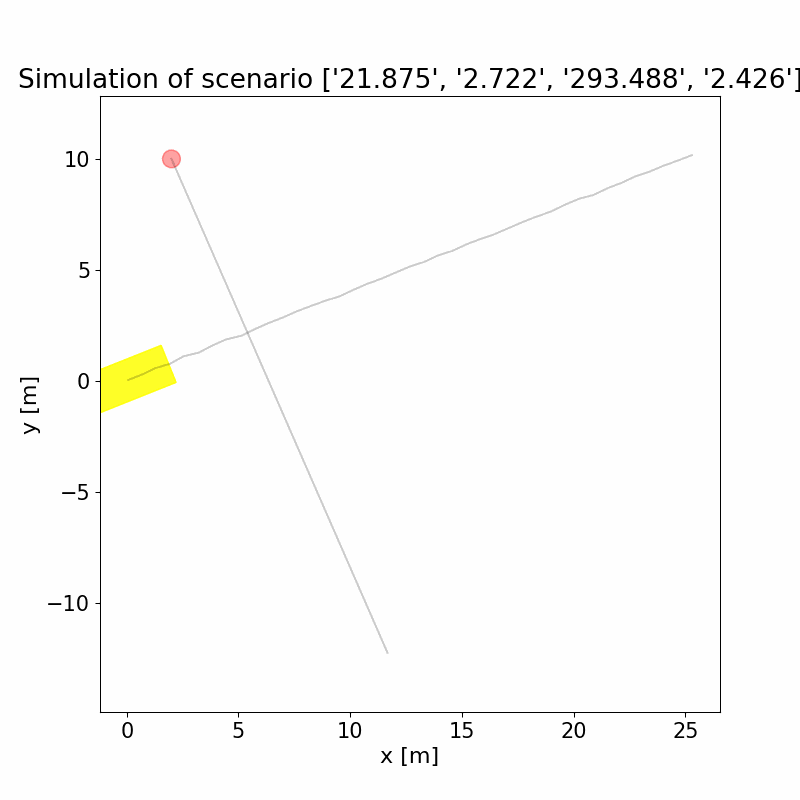

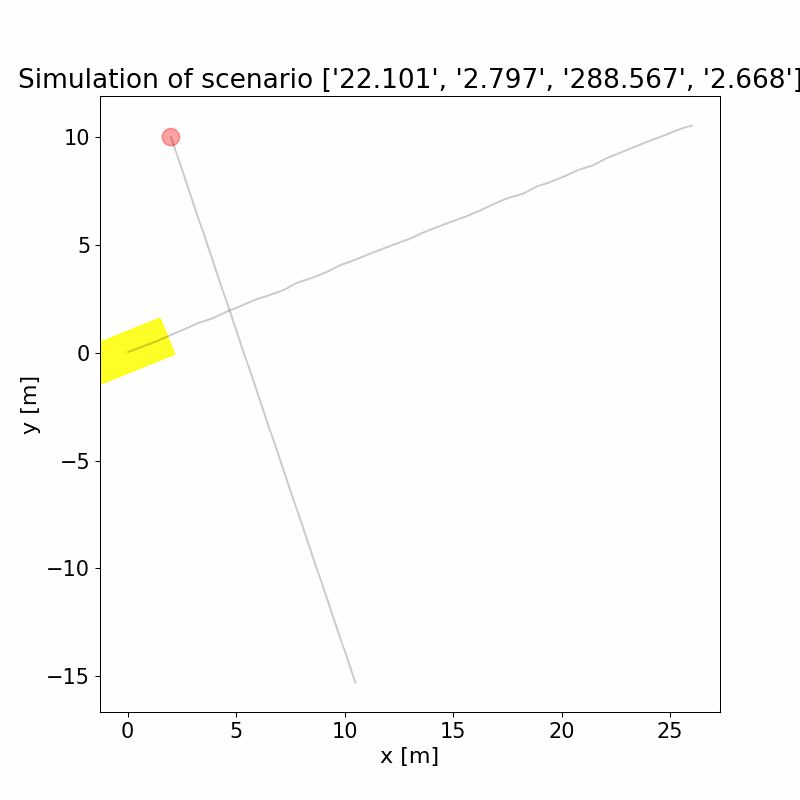

In [11]:
import pandas as pd
from pathlib import Path
import os

exp_folder = os.getcwd() + f"/results/DummySimulatorProblem/NSGA2/"
paths = sorted(Path(exp_folder).iterdir(), key=os.path.getmtime)
results_path = str(paths[-1])

from IPython.display import Image
import os

n = 4 # show max n images
folder_gifs = results_path + os.sep + "gif"
i = 0
for f in os.listdir(folder_gifs):
    fpath = folder_gifs + os.sep + f
    if os.path.isfile(fpath) and i < n:
      img = Image(open(fpath,'rb').read(), width=300, height=300)
      display(img)
      i = i+1

## Experiment Execution (Console)

To start the search through the console we need to create an `Experiment` instance. The experiment instance receives the following inputs:

- the experiment name (type `str`)
- the created problem (type `ADASProblem`) 
- the search algorithm (type `AlgorithmType`)
- the search configuration (type `SearchConfiguration`)

Note, that the algorithm that is passed is an enumeration value which need to be registed beforehand via the `algorithm.py` script.

```python
from experiment.experiment import Experiment
from algorithm.algorithm import AlgorithmType
from experiment.search_configuration import DefaultSearchConfiguration

experiment = Experiment(name="5",
                        problem=problem,
                        algorithm=AlgorithmType.NSGAII,
                        search_configuration=DefaultSearchConfiguration())
```

Then we register the experiment so that we can use it later via console.

```python
from experiment.experiment_store import experiments_store
experiments_store.register(experiment)
```

To start search via console we run the experiment with the name "5":

We can change the experiment parameters, such e.g., lower and upper bounds of the search parameters, the search time, iteration size or population size by using flags. In the following execution, we restrict the search by selecting a maximal angle of 90 degrees and use only 10 iterations for the genetic operations.

In [8]:
!python -m opensbt.run -e 5 -min 0 1 90 0.2 -max 90 10 90 3 \
-m  "orientation_ped" "velocity_ped" "orientation_ped" "velocity_ped" -i 10

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       50 |      1 |             - |             -
     2 |      100 |      4 |  0.5315212384 |         ideal
     3 |      150 |      4 |  0.0041669721 |         ideal
     4 |      200 |      2 |  8.2813038257 |         ideal
     5 |      250 |      3 |  0.1028223038 |         ideal
     6 |      300 |      3 |  0.6504096856 |         ideal
     7 |      350 |      4 |  0.9171545827 |         ideal
     8 |      400 |      5 |  0.3959370802 |         nadir
     9 |      450 |      5 |  0.0354422123 |         ideal
    10 |      500 |      4 |  0.1153790675 |         ideal


2024-01-26 16:40:21,368 INFO     Logging setup. Writing to file:  .\log.txt
2024-01-26 16:40:21,371 INFO     Selected experiment: 5
2024-01-26 16:40:21,372 INFO     Pymoo NSGA-II algorithm is used.
2024-01-26 16:40:21,381 INFO     Running evaluation number 1
2024-01-26 16:40:21,709 INFO     Running evaluation number 2
2024-01-26 16:40:22,301 INFO     Running evaluation number 3
2024-01-26 16:40:22,715 INFO     Running evaluation number 4
2024-01-26 16:40:23,450 INFO     Running evaluation number 5
2024-01-26 16:40:24,450 INFO     Running evaluation number 6
2024-01-26 16:40:25,228 INFO     Running evaluation number 7
2024-01-26 16:40:25,695 INFO     Running evaluation number 8
2024-01-26 16:40:25,962 INFO     Running evaluation number 9
2024-01-26 16:40:26,445 INFO     Running evaluation number 10
2024-01-26 16:40:26,681 INFO     =====[NSGA2] Writing results to: 
2024-01-26 16:40:26,683 INFO     C:\Users\Lev\Documents\fortiss\projects\testing\open-sbt\opensbt-core\docs\jupyter\opensbt-

We can then inspect some of the optimal test inputs that have been found:

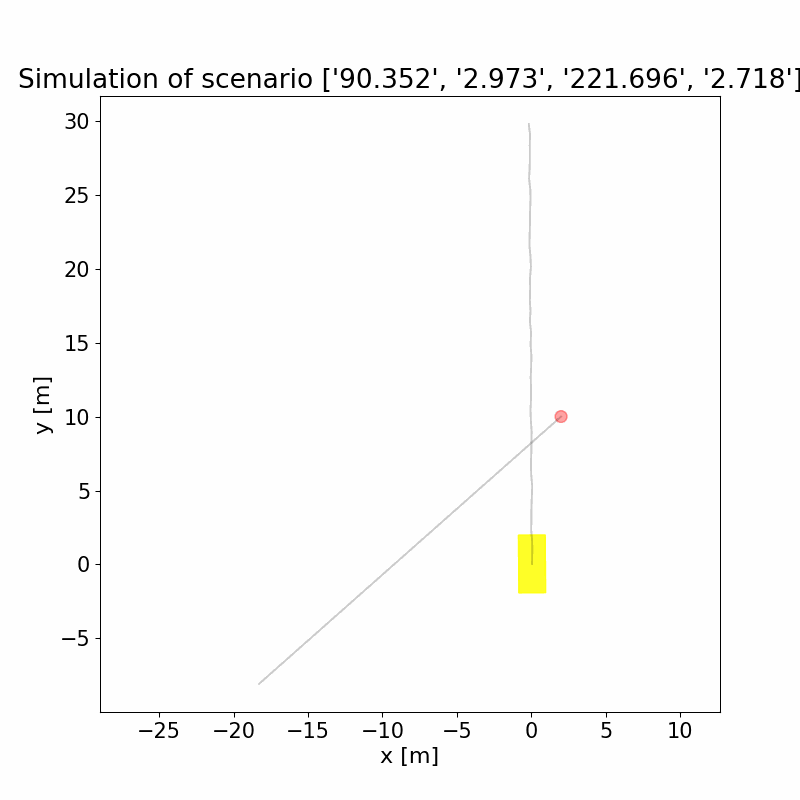

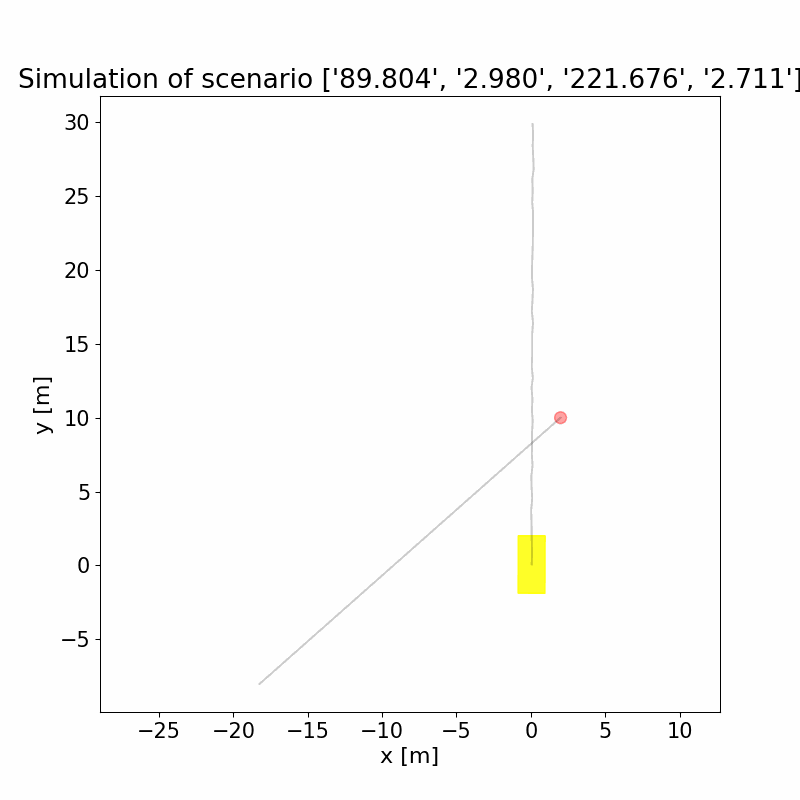

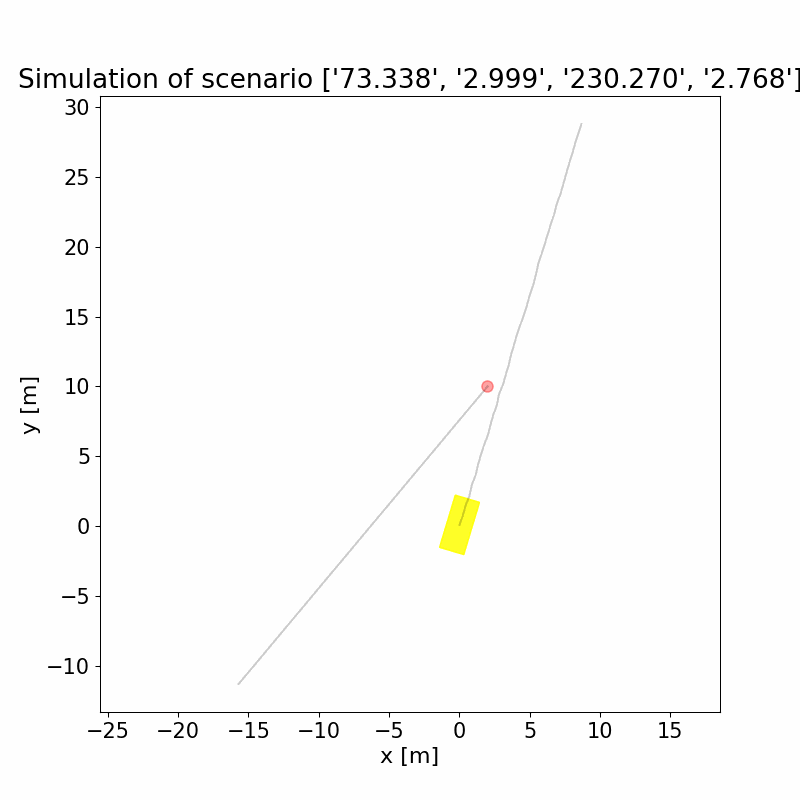

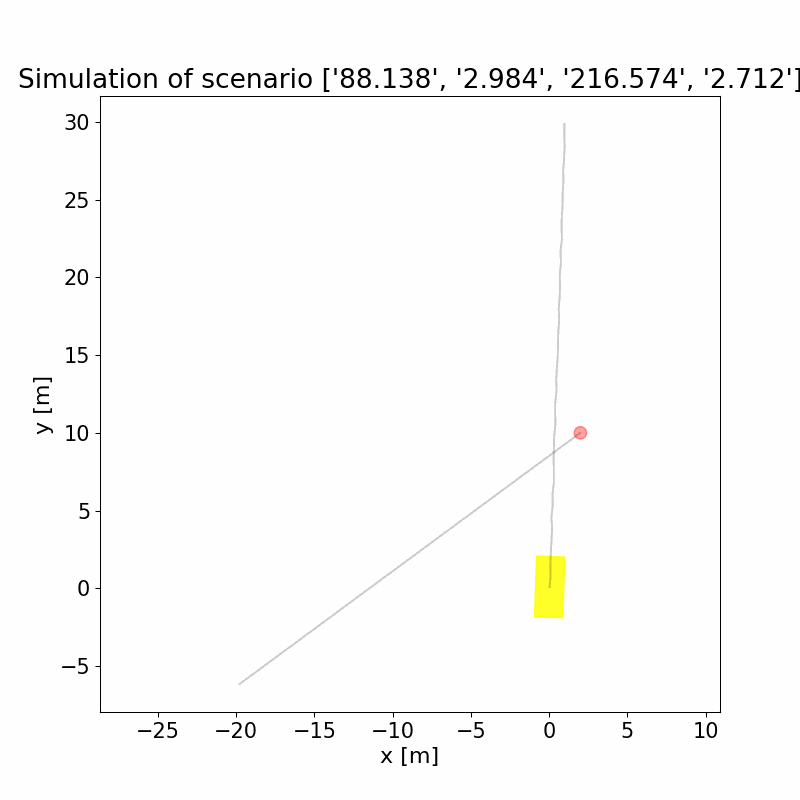

In [9]:
import pandas as pd
from pathlib import Path
import os

exp_folder = os.getcwd() + f"/results/DummySimulatorProblem/NSGA2/"
paths = sorted(Path(exp_folder).iterdir(), key=os.path.getmtime)
results_path = str(paths[-1])

from IPython.display import Image
import os

n = 4 # show max n images
folder_gifs = results_path + os.sep + "gif"
i = 0
for f in os.listdir(folder_gifs):
    fpath = folder_gifs + os.sep + f
    if os.path.isfile(fpath) and i < n:
      img = Image(open(fpath,'rb').read(), width=300, height=300)
      display(img)
      i = i+1

## Flags

The complete list of flags is provided below.

```
 -h, --help            show this help message and exit
  -e EXP_NUMBER         Name of existing experiment to be used. (show all experiments via -info)].
  -i N_GENERATIONS      Number of generations to perform.
  -n SIZE_POPULATION    The size of the initial population of scenario candidates.
  -a ALGORITHM          The algorithm to use for search (Number registered via AlgorithmType)
  -t MAXIMAL_EXECUTION_TIME
                        The time to use for search.
  -f SCENARIO_PATH      The path to the scenario description file.
  -min VAR_MIN [VAR_MIN ...]
                        The lower bound of each search parameter.
  -max VAR_MAX [VAR_MAX ...]
                        The upper bound of each search parameter.
  -m DESIGN_NAMES [DESIGN_NAMES ...]
                        The names of the variables to modify.
  -o RESULTS_FOLDER     The name of the folder where the results of the search are stored (default: /results/single/)
  -v                    Whether to use the simuator's visualization. This feature is useful for debugging and demonstrations, however it reduces the search performance.
  -info                 Names of all defined experiments.
```
